In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import re
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [2]:
# Define the size of the images
SIZE = 256

In [3]:
# Function to sort files in alphanumeric order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=alphanum_key)

In [4]:
# Function to load images
def load_images(path, limit=2200):
    images = []
    files = os.listdir(path)
    files = sorted_alphanumeric(files)
    
    for i in tqdm(files):
        if i == f'{limit}.jpg':
            break
        else:
            img = cv2.imread(os.path.join(path, i), 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            images.append(img)
    
    return np.array(images)


In [5]:
# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, color_images, gray_images):
        self.color_images = torch.FloatTensor(color_images)
        self.gray_images = torch.FloatTensor(gray_images)
        
    def __len__(self):
        return len(self.color_images)
    
    def __getitem__(self, idx):
        return self.gray_images[idx].permute(2, 0, 1), self.color_images[idx].permute(2, 0, 1)

In [6]:
# Function to create a PyTorch dataloader
def create_dataloaders(color_imgs, gray_imgs, batch_size=64, split=2000):
    # Train datasets
    train_dataset = ImageDataset(color_imgs[:split], gray_imgs[:split])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Test datasets
    test_dataset = ImageDataset(color_imgs[split:], gray_imgs[split:])
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    return train_dataloader, test_dataloader

In [7]:
# Downsample block (equivalent to the TF downsample function)
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(DownSample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels) if apply_batchnorm else None
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        return self.leaky_relu(x)

In [8]:
# Upsample block (equivalent to the TF upsample function)
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(UpSample, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if apply_dropout else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.deconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = self.dropout(x)
        return self.relu(x)

In [9]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder (Downsampling)
        self.down1 = DownSample(3, 64, apply_batchnorm=False)  # (bs, 64, 128, 128)
        self.down2 = DownSample(64, 128)  # (bs, 128, 64, 64)
        self.down3 = DownSample(128, 256)  # (bs, 256, 32, 32)
        self.down4 = DownSample(256, 512)  # (bs, 512, 16, 16)
        self.down5 = DownSample(512, 512)  # (bs, 512, 8, 8)
        self.down6 = DownSample(512, 512)  # (bs, 512, 4, 4)
        self.down7 = DownSample(512, 512)  # (bs, 512, 2, 2)
        self.down8 = DownSample(512, 512)  # (bs, 512, 1, 1)
        
        # Decoder (Upsampling)
        self.up1 = UpSample(512, 512, apply_dropout=True)  # (bs, 512, 2, 2)
        self.up2 = UpSample(1024, 512, apply_dropout=True)  # (bs, 512, 4, 4)
        self.up3 = UpSample(1024, 512, apply_dropout=True)  # (bs, 512, 8, 8)
        self.up4 = UpSample(1024, 512)  # (bs, 512, 16, 16)
        self.up5 = UpSample(1024, 256)  # (bs, 256, 32, 32)
        self.up6 = UpSample(512, 128)  # (bs, 128, 64, 64)
        self.up7 = UpSample(256, 64)  # (bs, 64, 128, 128)
        
        # Final layer
        self.final = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoding
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # Decoding with skip connections
        u1 = self.up1(d8)
        u1_cat = torch.cat([u1, d7], dim=1)
        u2 = self.up2(u1_cat)
        u2_cat = torch.cat([u2, d6], dim=1)
        u3 = self.up3(u2_cat)
        u3_cat = torch.cat([u3, d5], dim=1)
        u4 = self.up4(u3_cat)
        u4_cat = torch.cat([u4, d4], dim=1)
        u5 = self.up5(u4_cat)
        u5_cat = torch.cat([u5, d3], dim=1)
        u6 = self.up6(u5_cat)
        u6_cat = torch.cat([u6, d2], dim=1)
        u7 = self.up7(u6_cat)
        u7_cat = torch.cat([u7, d1], dim=1)
        
        output = self.final(u7_cat)
        return self.tanh(output)

In [10]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Downsampling layers
        self.down1 = DownSample(6, 64, apply_batchnorm=False)  # (bs, 64, 128, 128)
        self.down2 = DownSample(64, 128)  # (bs, 128, 64, 64)
        self.down3 = DownSample(128, 256)  # (bs, 256, 32, 32)
        
        # Zero padding + conv
        self.zero_pad1 = nn.ZeroPad2d(1)  # (bs, 256, 34, 34)
        self.conv = nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False)  # (bs, 512, 31, 31)
        self.bn = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        # Zero padding + final conv
        self.zero_pad2 = nn.ZeroPad2d(1)  # (bs, 512, 33, 33)
        self.final_conv = nn.Conv2d(512, 1, kernel_size=4, stride=1)  # (bs, 1, 30, 30)
        
    def forward(self, gray_image, color_image):
        # Concatenate the input and output images
        x = torch.cat([gray_image, color_image], dim=1)
        
        # Downsampling
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        
        # Conv layers with zero padding
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.leaky_relu(x)
        
        # Final conv with zero padding
        x = self.zero_pad2(x)
        x = self.final_conv(x)
        
        return x

In [11]:
# Loss functions
def generator_loss(disc_generated_output, gen_output, target, lambda_l1=100):
    # GAN loss
    gan_loss = F.binary_cross_entropy_with_logits(
        disc_generated_output, 
        torch.ones_like(disc_generated_output)
    )
    
    # L1 loss
    l1_loss = torch.mean(torch.abs(target - gen_output))
    
    # Total generator loss
    total_gen_loss = gan_loss + (lambda_l1 * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    # Real loss
    real_loss = F.binary_cross_entropy_with_logits(
        disc_real_output, 
        torch.ones_like(disc_real_output)
    )
    
    # Generated loss
    generated_loss = F.binary_cross_entropy_with_logits(
        disc_generated_output, 
        torch.zeros_like(disc_generated_output)
    )
    
    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [12]:
# Training function
def train(generator, discriminator, train_dataloader, num_epochs=50, device='cuda'):
    generator.to(device)
    discriminator.to(device)
    
    # Optimizers
    generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    # Lists to store loss values
    gen_losses = []
    disc_losses = []
    
    for epoch in range(num_epochs):
        start = time.time()
        print(f"Epoch: {epoch+1}/{num_epochs}")
        
        for i, (input_image, target) in enumerate(train_dataloader):
            input_image = input_image.to(device)
            target = target.to(device)
            
            # Train discriminator
            discriminator_optimizer.zero_grad()
            
            # Generate colorized image
            gen_output = generator(input_image)
            
            # Real vs fake discrimination
            disc_real_output = discriminator(input_image, target)
            disc_generated_output = discriminator(input_image, gen_output.detach())
            
            # Calculate discriminator loss
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
            disc_losses.append(disc_loss.item())
            
            # Backpropagation for discriminator
            disc_loss.backward()
            discriminator_optimizer.step()
            
            # Train generator
            generator_optimizer.zero_grad()
            
            # Discrimination on newly generated images
            disc_generated_output = discriminator(input_image, gen_output)
            
            # Calculate generator loss
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, target
            )
            gen_losses.append(gen_total_loss.item())
            
            # Backpropagation for generator
            gen_total_loss.backward()
            generator_optimizer.step()
            
            if i % 10 == 0:
                print(f"Batch {i}/{len(train_dataloader)}, Gen Loss: {gen_total_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")
                
        print(f'Time taken for epoch {epoch + 1} is {time.time()-start:.2f} sec\n')
    
    return gen_losses, disc_losses

In [13]:
# Function to generate images
def generate_images(model, test_input, target=None, device='cuda'):
    model.eval()
    with torch.no_grad():
        test_input = test_input.to(device)
        prediction = model(test_input)
    
    # Convert tensors to CPU and numpy for plotting
    test_input = test_input.cpu()
    prediction = prediction.cpu()
    
    plt.figure(figsize=(15, 15))
    
    if target is not None:
        target = target.cpu()
        display_list = [test_input[0].permute(1, 2, 0).numpy(), 
                        target[0].permute(1, 2, 0).numpy(), 
                        prediction[0].permute(1, 2, 0).numpy()]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        num_images = 3
    else:
        display_list = [test_input[0].permute(1, 2, 0).numpy(), 
                        prediction[0].permute(1, 2, 0).numpy()]
        title = ['Input Image', 'Predicted Image']
        num_images = 2
    
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.title(title[i])
        # Get the pixel values between [0, 1] to plot it
        img = np.clip(display_list[i], 0, 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    
    model.train()
    return prediction

In [14]:
# Main function to load data and train the model
def main():
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load image data
    color_path = "Dataset/landscape Images/color"
    gray_path = "Dataset/landscape Images/gray"
    
    print("Loading color images...")
    color_imgs = load_images(color_path)
    
    print("Loading grayscale images...")
    gray_imgs = load_images(gray_path)
    
    # Create dataloaders
    train_dataloader, test_dataloader = create_dataloaders(color_imgs, gray_imgs, batch_size=64)
    
    # Create the generator and discriminator models
    generator = Generator()
    discriminator = Discriminator()
    
    # Display model summaries
    print(generator)
    print(discriminator)
    
    # Train the models
    gen_losses, disc_losses = train(generator, discriminator, train_dataloader, num_epochs=50, device=device)
    
    # Plot the losses
    import seaborn as sns
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 4))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.title("GAN LOSS VALUES")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Generate example images from the test set
    for i, (input_image, target) in enumerate(test_dataloader):
        generate_images(generator, input_image, target, device=device)
        if i >= 10:  # Show 10 examples
            break
    
    # Save the model
    torch.save(generator.state_dict(), "colorization_generator.pth")
    torch.save(discriminator.state_dict(), "colorization_discriminator.pth")
    
    return generator, discriminator

Using device: cuda
Loading color images...


 31%|███       | 2200/7129 [00:01<00:04, 1101.65it/s]


Loading grayscale images...


 31%|███       | 2200/7129 [00:01<00:04, 1200.88it/s]


Generator(
  (down1): DownSample(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down2): DownSample(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down3): DownSample(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down4): DownSample(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down5): DownSample(
    (con

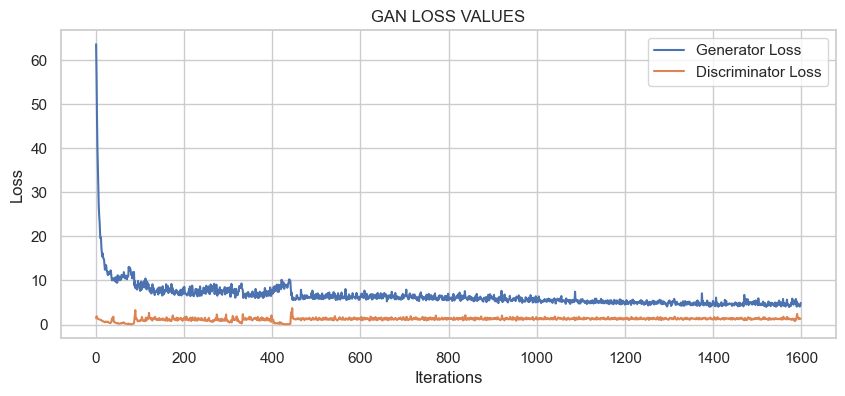

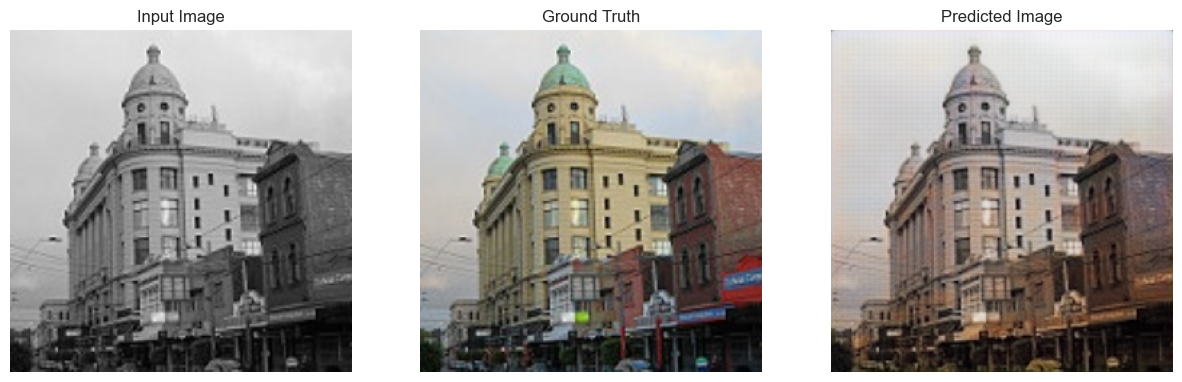

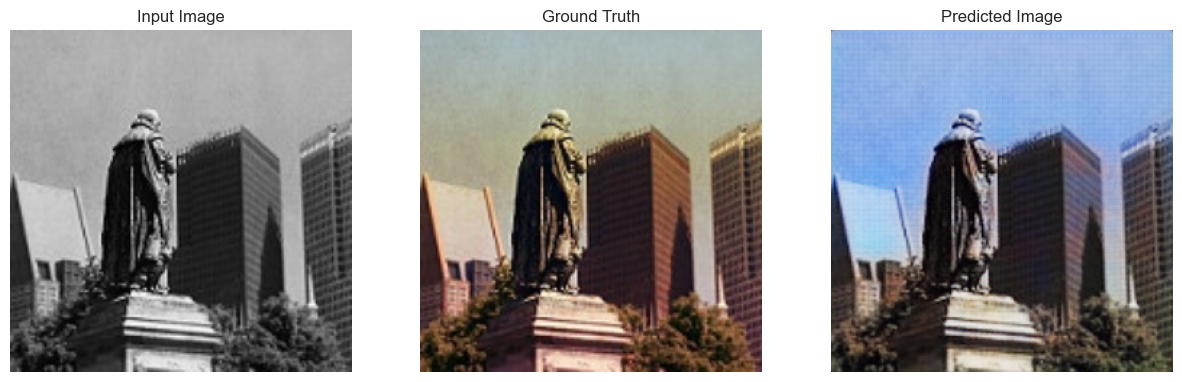

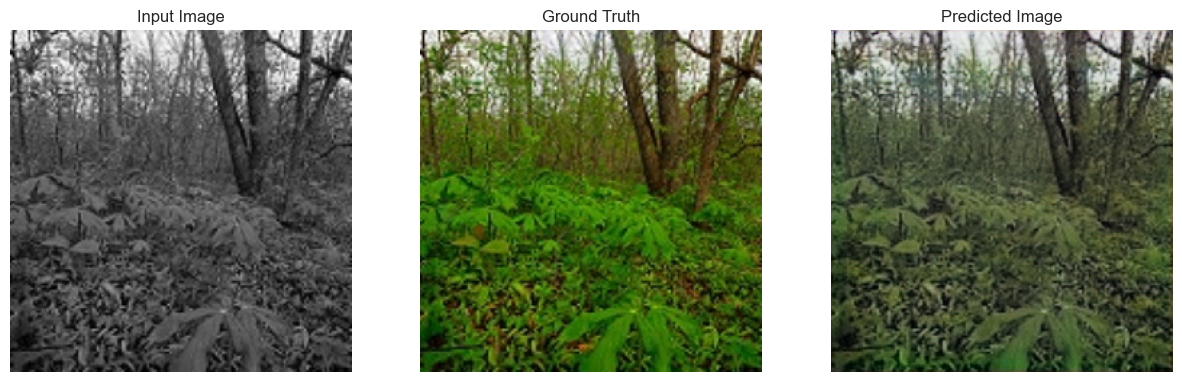

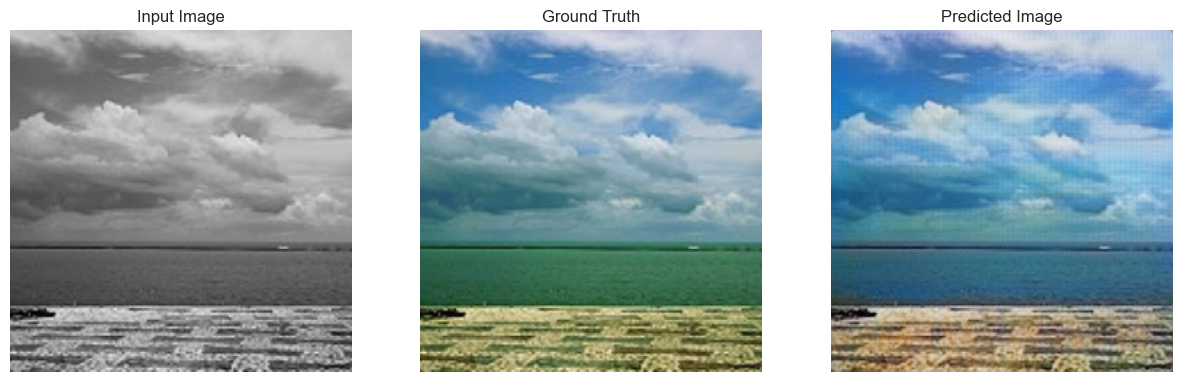

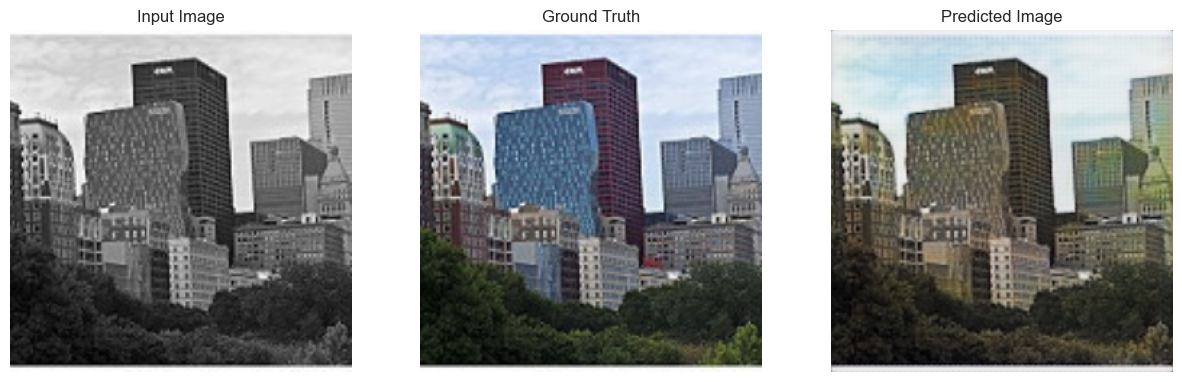

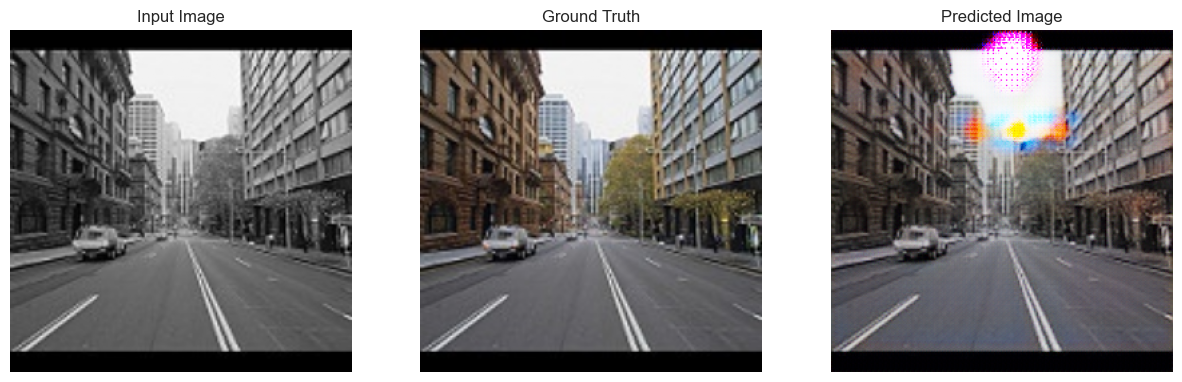

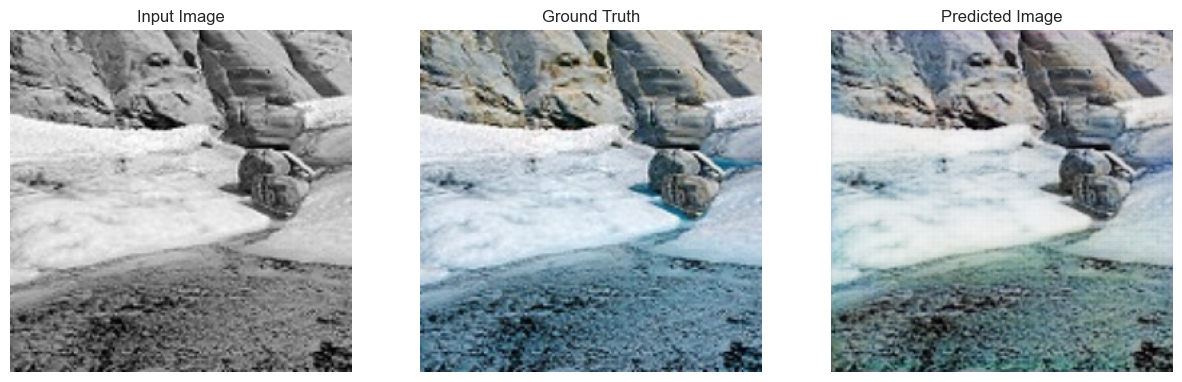

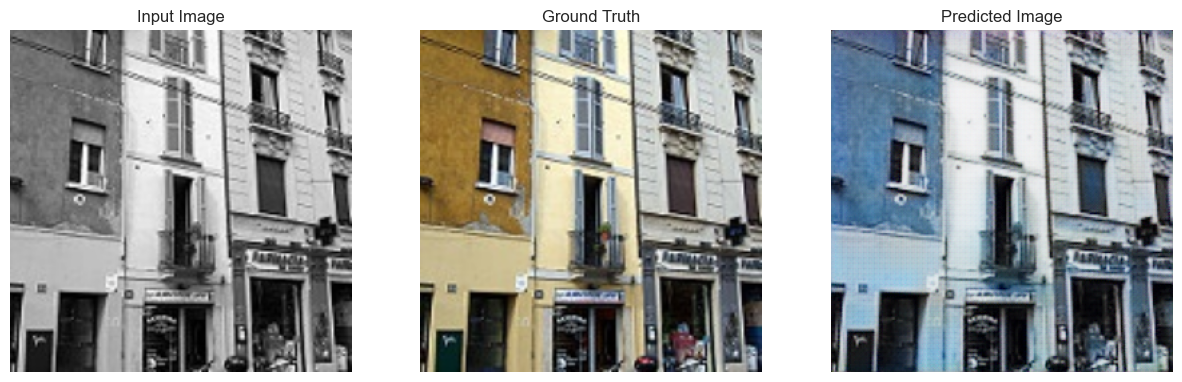

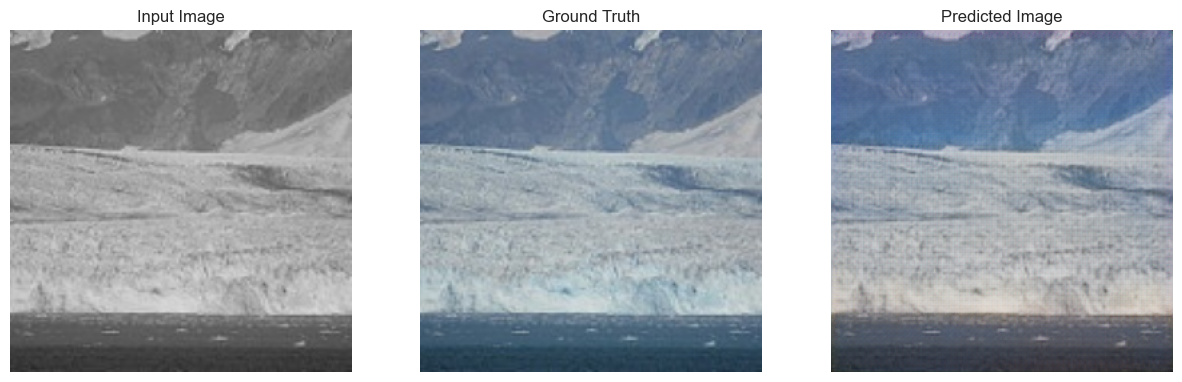

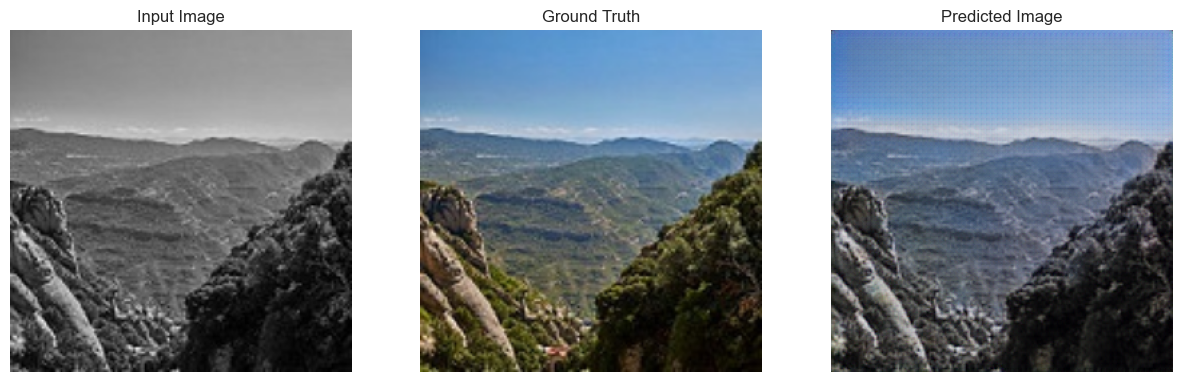

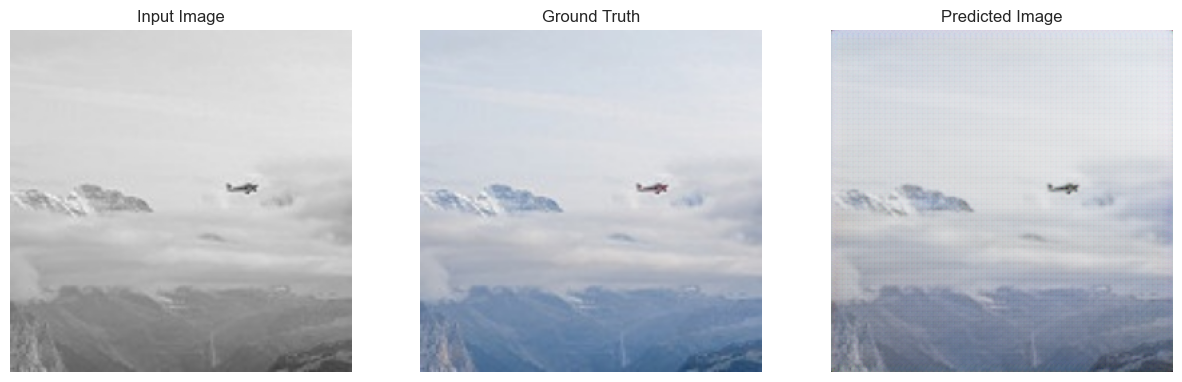

In [16]:
# Function to load a test image and colorize it
def colorize_test_image(generator, image_path, device='cuda'):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize and normalize
    try:
        img = cv2.resize(img, (SIZE, SIZE))
    except:
        pass  # Already the right size
    
    img = img.astype('float32') / 255.0
    
    # Convert to tensor
    img_tensor = torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0)
    
    # Generate colorized image
    generator.eval()
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        colorized = generator(img_tensor)
    
    # Display results
    generate_images(generator, img_tensor, device=device)
    
    return colorized

if __name__ == "__main__":
    generator, discriminator = main()
    
    # Test with a custom image
    # colorize_test_image(generator, "path/to/test/image.jpg")